# Setup

1.   **GPU Runtime**: click on the "Runtime" menu item in the top bar and select the "Change runtime type" option. Select "GPU" from the list of Hardware accelerators and click "Ok".  

2.   CUDA Compilation: we will use of the NVCC4Jupyter plugin which effectively turns any Colab Notebook code block that includes `%%cu` into compilable/runnable CUDA code.

In [ ]:
# first run this to install and load nvcc plugin
!pip install git+https://github.com/engasa/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/engasa/nvcc4jupyter.git to /tmp/pip-req-build-4cmkp2uh
  Running command git clone -q https://github.com/engasa/nvcc4jupyter.git /tmp/pip-req-build-4cmkp2uh
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4407 sha256=e79ef96450e757d288c7f5a1759fbcaf8d733d9d5c699fd55dd7adc6f8cd8715
  Stored in directory: /tmp/pip-ephem-wheel-cache-gwx4z4b5/wheels/d2/a3/04/ef659d715dcdd196d998813ca085af3cab3df66f4bb27576b5
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out




3.   Now you can check your CUDA installation by running the command below. The output should show you some info about the Cuda compiler, e.g., "*nvcc: NVIDIA (R) Cuda compiler driver Copyright (c) 2005-2021* ...etc"

In [ ]:
# check nvcc version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


4.   You can also check if GPU has been allocated. Colab notebooks without a GPU technically have access to NVCC and will compile and execute CPU/Host code, however, GPU/Device code will silently fail. To prevent such situations, this code will warn the user.


In [ ]:
%%cu
#include <stdio.h>
#include "device_launch_parameters.h"
int main() {
    int count;
    cudaGetDeviceCount(&count);
    if (count <= 0 || count > 100)  printf("!!!!! WARNING<-: NO GPU DETECTED ON THIS COLLABORATE INSTANCE. YOU SHOULD CHANGE THE RUNTIME TYPE.!!!!!\n");
    else                            printf("^^^^ GPU ENABLED! ^^^^\n");
    return 0;
}

^^^^ GPU ENABLED! ^^^^



If you see anything but "GPU ENABLED - ..etc", then repeat the above steps again.



---


# SANDBOX
Now you can try your own CUDA code in the box below.
Note that %%cu is used to switch the mode to CUDA

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>

//you may use this macro for error checking
#define CHK(call) {cudaError_t err = call; if (err != cudaSuccess) { printf("Error%d: %s:%d\n",err,__FILE__,__LINE__); printf(cudaGetErrorString(err)); cudaDeviceReset(); exit(1);}}

__global__ void kernel(){

}

int main(){

    return 0;
}



---


#Q1

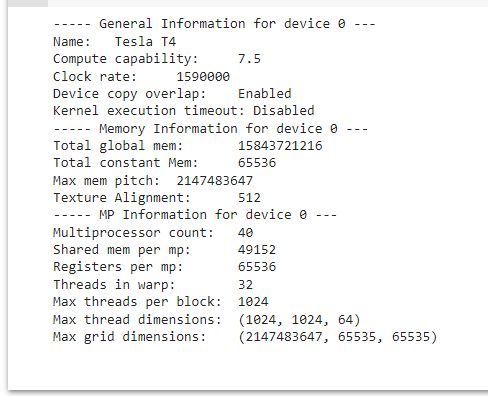



---


#Q2

### (a) Serial Code

In [ ]:
%%cu
#include "cuda_runtime.h"
#include <stdlib.h>
#include <stdio.h>
#include <time.h>

int main() {
  const int n = 10000000;
  double * a = (double*)(malloc(n*sizeof(double)));

  if (a == NULL) {
      printf("Error, failed to allocate space for %d integers", n);
      exit(0);
  }

  clock_t start = clock();
  for (int i = 0; i < n; i++) {
      a[i] = (double)i / n;
  }
  clock_t stop = clock();

  printf("Processing Time: %.7f sec\n", (double)(stop-start) / CLOCKS_PER_SEC);

  for (int i = 0; i<5; i++) {
      printf("a[%d] = %.7f\n", i, a[i]);
  }

  for (int i = (n-5); i<n; i++) {
      printf("a[%d] = %.7f\n", i, a[i]);
  }

  free(a);

  return 0;
}

Processing Time: 0.0882330 sec
a[0] = 0.0000000
a[1] = 0.0000001
a[2] = 0.0000002
a[3] = 0.0000003
a[4] = 0.0000004
a[9999995] = 0.9999995
a[9999996] = 0.9999996
a[9999997] = 0.9999997
a[9999998] = 0.9999998
a[9999999] = 0.9999999



### (b) Parallel Code

In [ ]:
%%cu
#include <stdio.h>
#include <time.h>

__global__ void initA(double* a, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i<N) {
        a[i] = (double) i / N;
    }
}

int main() {
    const int N = 10000000;
    double *in = (double*)(malloc(N*sizeof(double)));

    if (in == NULL) {
        printf("Error, failed to allocate space for %d integers", N);
        exit(0);
    }

    double *a;
    const int SIZE_BYTES = N * sizeof(double);
    cudaMalloc(&a, SIZE_BYTES);

    cudaMemcpy(a, in, SIZE_BYTES, cudaMemcpyHostToDevice);
    clock_t start = clock();
    initA<<<10000, 1000>>>(a, N);
    clock_t stop = clock();
    cudaMemcpy(in, a, SIZE_BYTES, cudaMemcpyDeviceToHost);

    printf("Processing Time: %.7f sec\n", (double)(stop-start) / CLOCKS_PER_SEC);

    for (int i = 0; i<5; i++) {
        printf("a[%d] = %.7f\n", i, in[i]);
    }

    for (int i = (N-5); i<N; i++) {
        printf("a[%d] = %.7f\n", i, in[i]);
    }

    free(in);
    cudaFree(a);

    return 0;

}



Processing Time: 0.0000260 sec
a[0] = 0.0000000
a[1] = 0.0000001
a[2] = 0.0000002
a[3] = 0.0000003
a[4] = 0.0000004
a[9999995] = 0.9999995
a[9999996] = 0.9999996
a[9999997] = 0.9999997
a[9999998] = 0.9999998
a[9999999] = 0.9999999

